In [1]:
import os

num_threads = "20"
# Set the maximum number of threads
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads
os.environ["NUMBA_NUM_THREADS"] = num_threads

In [2]:
import pandas as pd
import numpy as np
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from tqdm import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
def train_model(df, feat_cols, split_group, pred_vars, results_path, pred_path, mean_pred = "no"):
    results = []
    pred_obs = []
    for var in pred_vars:

        # Group split logic
        groups = df[split_group]
        gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        
        for split_idx, (train_idx, test_idx) in tqdm(enumerate(gss.split(df, groups=groups)), desc=f"Processing {var}"):
            # Splitting the dataset
            train_data = df.iloc[train_idx]
            test_data = df.iloc[test_idx]

            train_data = train_data.dropna(subset=[var]).reset_index(drop=True)
            test_data = test_data.dropna(subset=[var]).reset_index(drop=True)
            
            X_train = train_data[feat_cols]
            y_train = train_data[var]
            X_test = test_data[feat_cols]
            y_test = test_data[var]

            if mean_pred == "yes":
                mean_value = np.mean(y_train)
                predictions = np.full(len(y_test), mean_value)
            else: 
                model = xgb.XGBRegressor(objective="reg:squarederror")
                model.fit(X_train, y_train)
                predictions = model.predict(X_test)

            # Calculate performance
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, predictions)

            results.append((var, split_idx, r2, rmse, mae))
            pred_obs.append(pl.DataFrame({
                "Predicted": predictions,
                "Observed": y_test.values,
                "Metadata_Plate": test_data["Metadata_Plate"].values,
                "Metadata_Well": test_data["Metadata_Well"].values,
                "Variable": var,
            }))

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results, columns=["Variable", "Split", "R²", "RMSE", "MAE"])
    pred_obs_df = pl.concat(pred_obs, how="vertical")

    # Save results
    results_df.to_csv(results_path, index=False)
    pred_obs_df.write_csv(pred_path)


def process_prof(dat_path):
    df = pd.read_parquet(dat_path)
    morph_feats = [i for i in df.columns if "Metadata" not in i]
    meta_feats = [i for i in df.columns if "Metadata" in i]

    df = df[df["Metadata_Perturbation"] != "DMSO_0.0"].reset_index(drop=True)

    df["Metadata_Log10Conc"] = np.round(df["Metadata_Log10Conc"], 2)

    # Encoding categorical columns
    df["Metadata_Plate"] = df["Metadata_Plate"].astype("category").cat.codes
    df["Metadata_source"] = df["Metadata_source"].astype("category").cat.codes
    df["Metadata_Well"] = df["Metadata_Well"].astype("category").cat.codes
    df["Metadata_Compound"] = df["Metadata_Compound"].astype("category").cat.codes

    return df


# Define a function to plot violin and swarm plots grouped by variable types
def violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels):
    combined_data = []
    for label, df in dataframes.items():
        # Filter rows based on the variable type
        filtered_df = df[df['Variable'].str.contains(variable_type)]
        if metric in metrics:
            for index, value in filtered_df[metric].items():
                combined_data.append({"Dataset": label.split('/')[-1], "Variable": variable_type, metric: value})
    
    # Convert combined data to DataFrame for plotting
    combined_df = pd.DataFrame(combined_data)
    
    plt.figure(figsize=(5, 5), dpi=100)
    sns.violinplot(data=combined_df, x="Dataset", y=metric, inner="box", palette="Accent", hue="Dataset", legend=False)
    sns.swarmplot(data=combined_df, x="Dataset", y=metric, color="k", alpha=1, s=3)
    
    # Set custom labels
    plt.xlabel("Dataset")
    plt.ylabel(metric)
    plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [4]:
cp_path = "/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cellprofiler/mad_featselect/profiles/mad_featselect.parquet"
cp_df = process_prof(cp_path)
cp_feat = [i for i in cp_df.columns if "Metadata" not in i]

## Train the baseline model

In [15]:
train_model(cp_df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Log10Conc", "Metadata_Count_Cells"],
            "Metadata_Compound",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'],
            "baseline_resid/results_compound_split_baseline.csv",
            "baseline_resid/predictions_compound_split_baseline.csv",)
print("Done 1")

Processing Metadata_ldh_normalized: 5it [00:02,  2.19it/s]
Processing Metadata_mtt_normalized: 5it [00:02,  2.39it/s]

Done 1


## Examine baseline residuals

In [19]:
resid_df = pd.read_csv("baseline_resid/predictions_compound_split_baseline.csv")

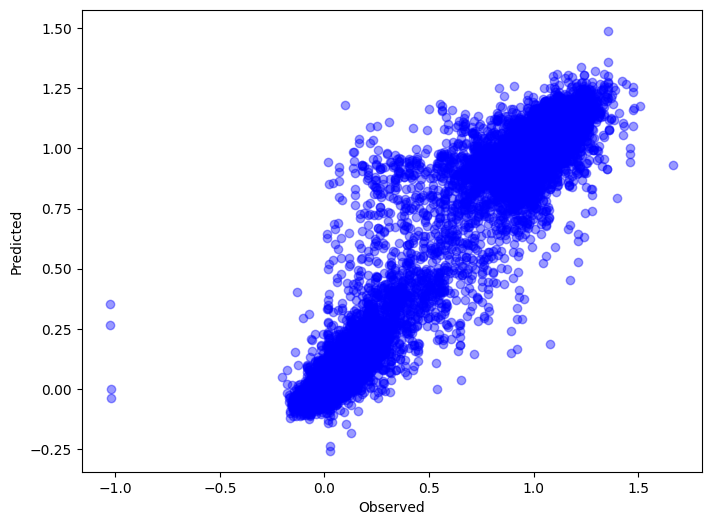

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(resid_df["Observed"], resid_df["Predicted"], alpha=0.4, c="blue")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.show()

## Add residuals to original dataframe

In [10]:
formula = "Metadata_mtt_normalized ~ Metadata_Count_Cells + (1|Metadata_source) + (1|Metadata_Plate) + (1|Metadata_Well)"

df = pd.read_parquet(cp_path)
df = df.dropna(subset=["Metadata_ldh_ridge_norm"])

# MTT
model = smf.mixedlm(
    "Metadata_mtt_normalized ~ Metadata_Count_Cells",
    data=df,
    groups=df["Metadata_source"],
    re_formula="~1",
    vc_formula={
        "Metadata_Plate": "0 + C(Metadata_Plate)",
        "Metadata_Well": "0 + C(Metadata_Well)"
    }
)

result = model.fit()
df["Metadata_mtt_resid"] = result.resid

# LDH
model = smf.mixedlm(
    "Metadata_ldh_normalized ~ Metadata_Count_Cells",
    data=df,
    groups=df["Metadata_source"],
    re_formula="~1",
    vc_formula={
        "Metadata_Plate": "0 + C(Metadata_Plate)",
        "Metadata_Well": "0 + C(Metadata_Well)"
    }
)

result = model.fit()
df["Metadata_ldh_resid"] = result.resid

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


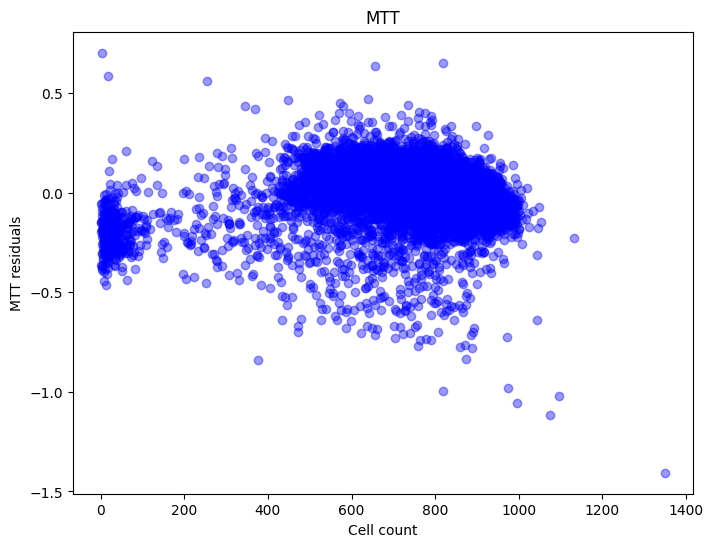

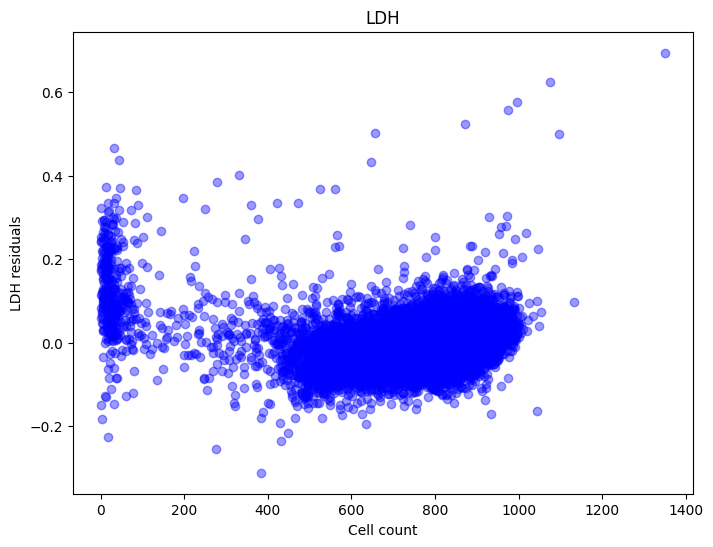

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(df["Metadata_Count_Cells"], df["Metadata_mtt_resid"], alpha=0.4, c="blue")
plt.xlabel("Cell count")
plt.ylabel("MTT residuals")
plt.title("MTT")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df["Metadata_Count_Cells"], df["Metadata_ldh_resid"], alpha=0.4, c="blue")
plt.xlabel("Cell count")
plt.ylabel("LDH residuals")
plt.title("LDH")
plt.show()

In [6]:
# Process like other analyses
morph_feats = [i for i in df.columns if "Metadata" not in i]
meta_feats = [i for i in df.columns if "Metadata" in i]

df = df[df["Metadata_Perturbation"] != "DMSO_0.0"].reset_index(drop=True)

df["Metadata_Log10Conc"] = np.round(df["Metadata_Log10Conc"], 2)

df["Metadata_Plate"] = df["Metadata_Plate"].astype("category").cat.codes
df["Metadata_source"] = df["Metadata_source"].astype("category").cat.codes
df["Metadata_Well"] = df["Metadata_Well"].astype("category").cat.codes
df["Metadata_Compound"] = df["Metadata_Compound"].astype("category").cat.codes

## Train models to predict the residuals

In [7]:
# Generate all results
pred_vars = ['Metadata_ldh_resid', 'Metadata_mtt_resid']

train_model(df, 
            [],
            "Metadata_Compound",
            pred_vars,
            "baseline_resid_preds/results_compound_split_mean_baseline.csv",
            "baseline_resid_preds/predictions_compound_split_mean_baseline.csv",
            "yes")
print("Done 1")


train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            pred_vars,
            "baseline_resid_preds/results_compound_split_source_well_plate_cc_baseline.csv",
            "baseline_resid_preds/predictions_compound_split_source_well_plate_cc_baseline.csv",
            )
print("Done 2")

train_model(df, 
            ["Metadata_Count_Cells"],
            "Metadata_Compound",
            pred_vars,
            "baseline_resid_preds/results_compound_split_cc_baseline.csv",
            "baseline_resid_preds/predictions_compound_split_cc_baseline.csv",           
            )
print("Done 3")

train_model(df, 
            ["Metadata_Well"],
            "Metadata_Compound",
            pred_vars,
            "baseline_resid_preds/results_compound_split_well_baseline.csv",
            "baseline_resid_preds/predictions_compound_split_well_baseline.csv",
            )
print("Done 4")

train_model(df, 
            ["Metadata_Plate"],
            "Metadata_Compound",
            pred_vars,
            "baseline_resid_preds/results_compound_split_plate_baseline.csv",
            "baseline_resid_preds/predictions_compound_split_plate_baseline.csv",
            )
print("Done 5")

train_model(df, 
            ["Metadata_source"],
            "Metadata_Compound",
            pred_vars,
            "baseline_resid_preds/results_compound_split_source_baseline.csv",
            "baseline_resid_preds/predictions_compound_split_source_baseline.csv",
            )
print("Done 6")

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            pred_vars,
            "baseline_resid_preds/results_compound_split_source_plate_well_baseline.csv",
            "baseline_resid_preds/predictions_compound_split_source_plate_well_baseline.csv",
            )
print("Done 7")

train_model(df, 
            morph_feats,
            "Metadata_Compound",
            pred_vars,
            "baseline_resid_preds/results_compound_split_cellprofiler.csv",
            "baseline_resid_preds/predictions_compound_split_cellprofiler.csv",
            )
print("Done 8")


Processing Metadata_ldh_resid: 5it [00:00, 10.82it/s]
Processing Metadata_mtt_resid: 5it [00:00, 13.41it/s]


Done 1


Processing Metadata_ldh_resid: 5it [00:01,  4.36it/s]
Processing Metadata_mtt_resid: 5it [00:01,  4.98it/s]


Done 2


Processing Metadata_ldh_resid: 5it [00:00,  6.09it/s]
Processing Metadata_mtt_resid: 5it [00:00,  5.70it/s]


Done 3


Processing Metadata_ldh_resid: 5it [00:00,  6.65it/s]
Processing Metadata_mtt_resid: 5it [00:00,  6.08it/s]


Done 4


Processing Metadata_ldh_resid: 5it [00:00,  8.19it/s]
Processing Metadata_mtt_resid: 5it [00:00,  7.70it/s]


Done 5


Processing Metadata_ldh_resid: 5it [00:00,  8.76it/s]
Processing Metadata_mtt_resid: 5it [00:00,  8.79it/s]


Done 6


Processing Metadata_ldh_resid: 5it [00:00,  5.34it/s]
Processing Metadata_mtt_resid: 5it [00:00,  5.41it/s]


Done 7


Processing Metadata_ldh_resid: 5it [00:27,  5.44s/it]
Processing Metadata_mtt_resid: 5it [00:26,  5.27s/it]

Done 8


Metadata_ldh_resid


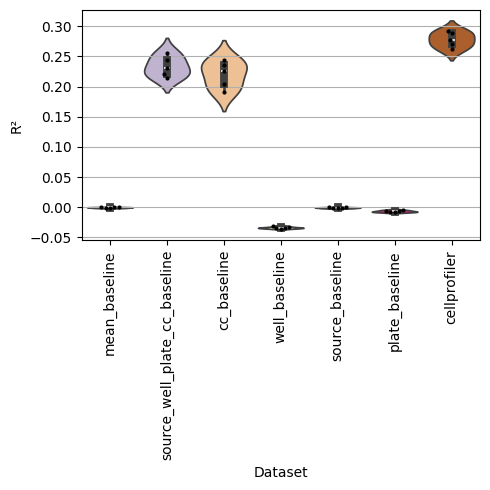

Metadata_ldh_resid


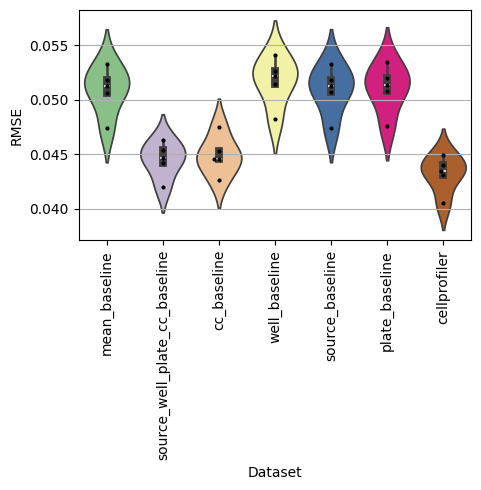

Metadata_ldh_resid


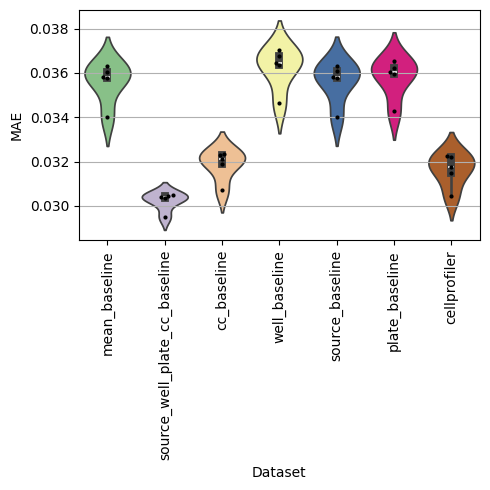

Metadata_mtt_resid


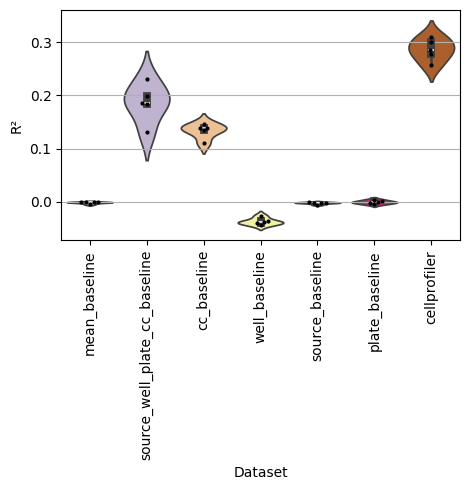

Metadata_mtt_resid


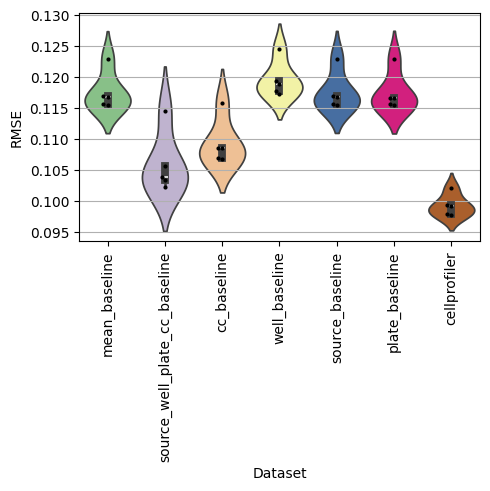

Metadata_mtt_resid


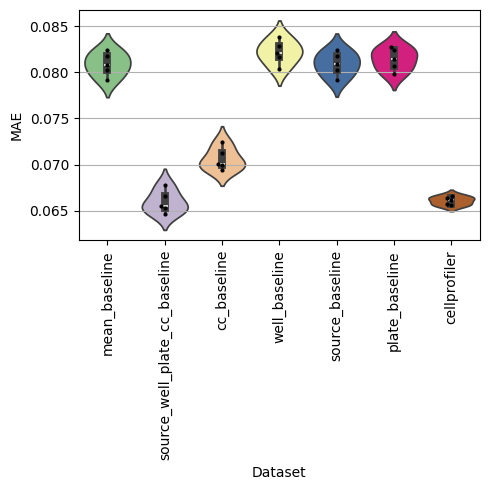

In [8]:
# Load the datasets
file_paths = [
    "baseline_resid_preds/results_compound_split_mean_baseline.csv",
    "baseline_resid_preds/results_compound_split_source_well_plate_cc_baseline.csv",
    "baseline_resid_preds/results_compound_split_cc_baseline.csv",
    "baseline_resid_preds/results_compound_split_well_baseline.csv",
    "baseline_resid_preds/results_compound_split_source_baseline.csv",
    "baseline_resid_preds/results_compound_split_plate_baseline.csv",
    "baseline_resid_preds/results_compound_split_cellprofiler.csv",
]

custom_labels = [path.replace("baseline_resid_preds/results_compound_split_", "").replace(".csv", "") for path in file_paths]

# Reading the CSV files into DataFrames
dataframes = {path: pd.read_csv(path) for path in file_paths}
metrics = ["R²", "RMSE", "MAE"]
    
# Generate plots for both variable types
variable_types = pred_vars
for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels)

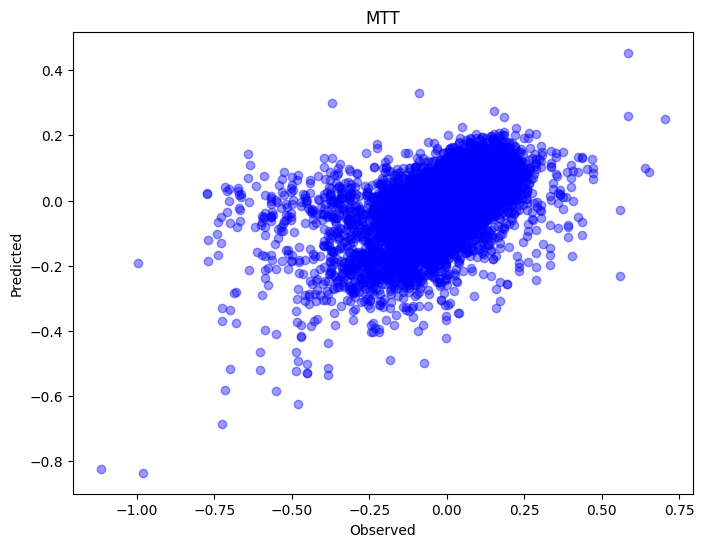

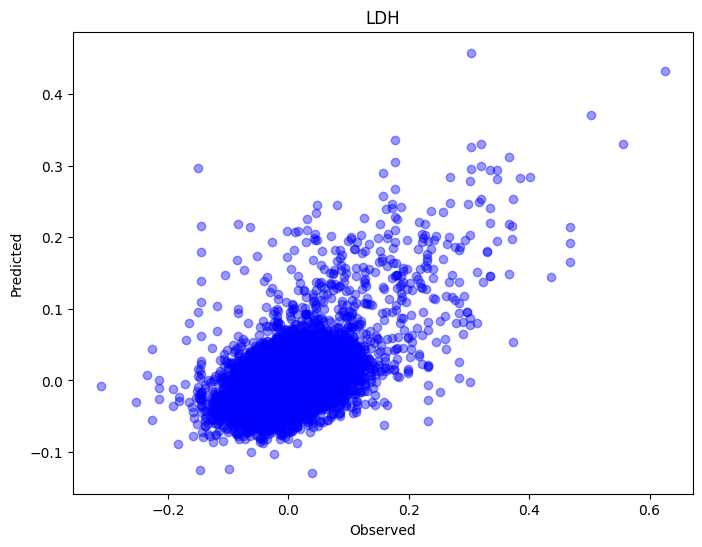

In [9]:
df = pd.read_csv("baseline_resid_preds/predictions_compound_split_cellprofiler.csv")
mtt_df = df[df["Variable"] == "Metadata_mtt_resid"]
ldh_df = df[df["Variable"] == "Metadata_ldh_resid"]

plt.figure(figsize=(8, 6))
plt.scatter(mtt_df["Observed"], mtt_df["Predicted"], alpha=0.4, c="blue")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("MTT")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(ldh_df["Observed"], ldh_df["Predicted"], alpha=0.4, c="blue")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("LDH")
plt.show()

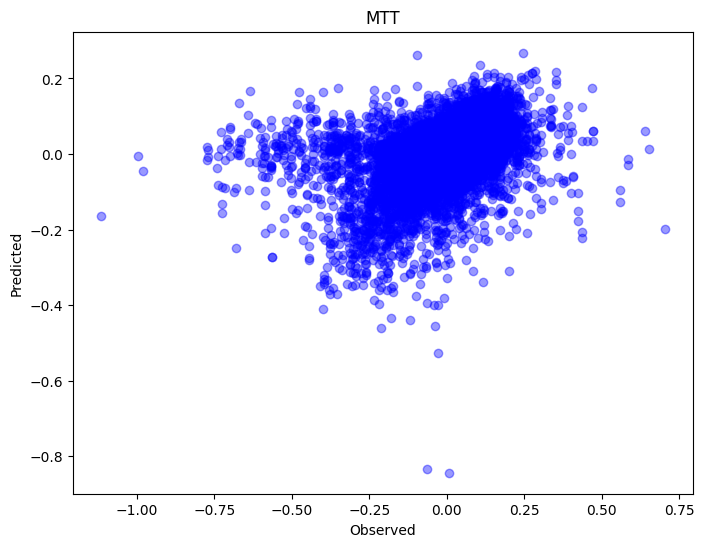

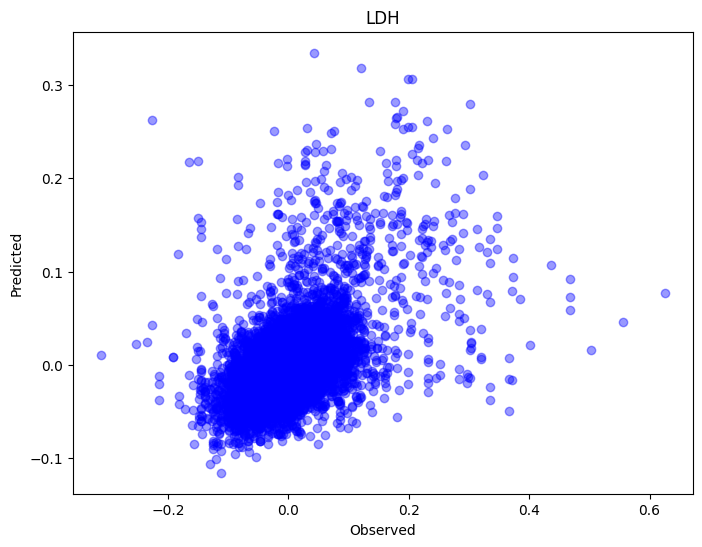

In [13]:
df = pd.read_csv("baseline_resid_preds/predictions_compound_split_source_well_plate_cc_baseline.csv")
mtt_df = df[df["Variable"] == "Metadata_mtt_resid"]
ldh_df = df[df["Variable"] == "Metadata_ldh_resid"]

plt.figure(figsize=(8, 6))
plt.scatter(mtt_df["Observed"], mtt_df["Predicted"], alpha=0.4, c="blue")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("MTT")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(ldh_df["Observed"], ldh_df["Predicted"], alpha=0.4, c="blue")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("LDH")
plt.show()

In [23]:
# Compare residuals for different predictions
bl_df = pd.read_csv("baseline_resid_preds/predictions_compound_split_source_well_plate_cc_baseline.csv")
morph_df = pd.read_csv("baseline_resid_preds/predictions_compound_split_cellprofiler.csv")

bl_df["Pred_residuals_bl"] = bl_df["Predicted"] - bl_df["Observed"]
morph_df["Pred_residuals_morph"] = morph_df["Predicted"] - morph_df["Observed"]

bl_df = bl_df[["Metadata_Plate", "Metadata_Well", "Variable", "Pred_residuals_bl"]].groupby(["Metadata_Plate", "Metadata_Well", "Variable"]).mean().reset_index()
morph_df = morph_df[["Metadata_Plate", "Metadata_Well", "Variable", "Pred_residuals_morph"]].groupby(["Metadata_Plate", "Metadata_Well", "Variable"]).mean().reset_index()

all_df = bl_df.merge(morph_df, on=["Metadata_Plate", "Metadata_Well", "Variable"])

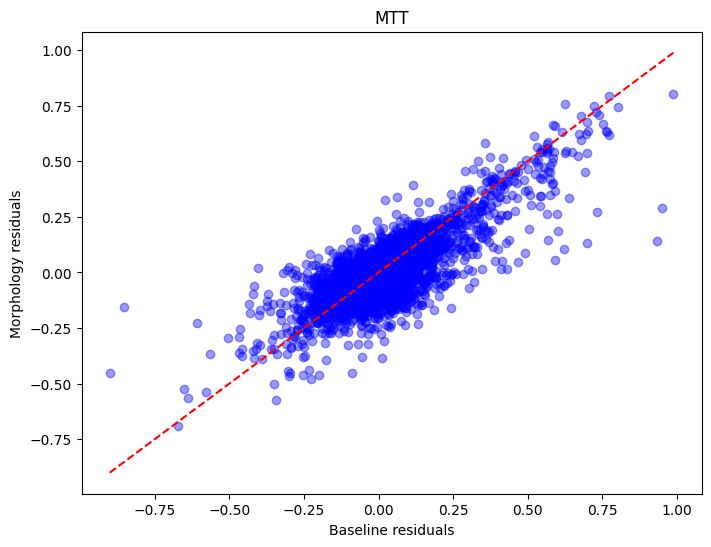

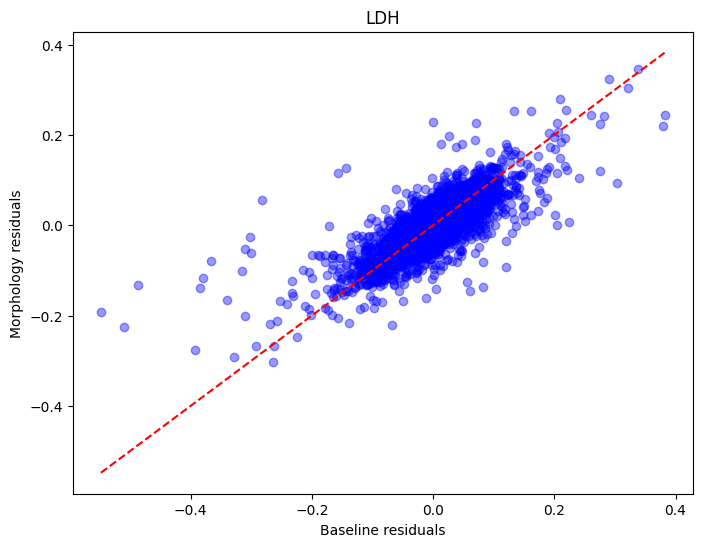

In [27]:
mtt_df = all_df[all_df["Variable"] == "Metadata_mtt_resid"]
ldh_df = all_df[all_df["Variable"] == "Metadata_ldh_resid"]

plt.figure(figsize=(8, 6))
plt.scatter(mtt_df["Pred_residuals_bl"], mtt_df["Pred_residuals_morph"], alpha=0.4, c="blue")
min_val = min(mtt_df["Pred_residuals_bl"].min(), mtt_df["Pred_residuals_morph"].min())
max_val = max(mtt_df["Pred_residuals_bl"].max(), mtt_df["Pred_residuals_morph"].max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="1:1 Line")
plt.xlabel("Baseline residuals")
plt.ylabel("Morphology residuals")
plt.title("MTT")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(ldh_df["Pred_residuals_bl"], ldh_df["Pred_residuals_morph"], alpha=0.4, c="blue")
min_val = min(ldh_df["Pred_residuals_bl"].min(), ldh_df["Pred_residuals_morph"].min())
max_val = max(ldh_df["Pred_residuals_bl"].max(), ldh_df["Pred_residuals_morph"].max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="1:1 Line")
plt.xlabel("Baseline residuals")
plt.ylabel("Morphology residuals")
plt.title("LDH")
plt.show()